In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns


We observed that the offering.csv data in HW1 refers only to the submissions in 2022 Quarter 3(it doesn't refer to the observations whose 'SALE_DATE' is in 2022Q3). To get an accurate analysis result, we downloaded all data from 2016Q4 to 2022Q3 from the SEC's website.  
    
The use of additional data also helped resolve the 'data imbalance' issue. In 2022Q3 data, more than 70 percent of the observations have a "SALE_DATE" after 2022, despite the earliest sale date being 1985. After aggregating all datasets, the number of observations is roughly balanced over time.

In [2]:
data = []
for file in os.listdir('Data'):
    if not file.startswith('20'):
        continue
    df = pd.read_csv('Data/' + file + '/OFFERING.tsv', sep='\t')
    data.append(df)
df = pd.concat(data, axis=0)

/var/folders/nl/r462b8753n571z9w1pbv8hcc0000gn/T/ipykernel_1795/886720627.py:5: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/' + file + '/OFFERING.tsv', sep='\t')


In [3]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])
df['SALE_DATE'].describe()

/var/folders/nl/r462b8753n571z9w1pbv8hcc0000gn/T/ipykernel_1795/779564720.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['SALE_DATE'].describe()


count                  254131
unique                   5065
top       2018-01-01 00:00:00
freq                      673
first     1968-08-01 00:00:00
last      2022-09-30 00:00:00
Name: SALE_DATE, dtype: object

In [4]:
df = df[['MINIMUMINVESTMENTACCEPTED', 'SALE_DATE', 'INDUSTRYGROUPTYPE', 'ACCESSIONNUMBER']]

In [5]:
df['SALE_QUARTER'] = pd.PeriodIndex(df['SALE_DATE'], freq='Q')

### It can be seen that, the number of observations with sale date before 2016 is very low, but is very high after 2016.

SALE_QUARTER
1968Q3        6
1971Q2        5
1973Q2        6
1976Q1        4
1976Q3        6
          ...  
2021Q3    10386
2021Q4    11481
2022Q1     9871
2022Q2     8215
2022Q3     5509
Freq: Q-DEC, Name: SALE_DATE, Length: 165, dtype: int64

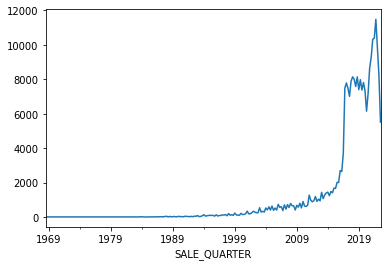

In [6]:
count_over_quarter = df.groupby('SALE_QUARTER')['SALE_DATE'].count()
count_over_quarter.plot()
count_over_quarter

### Since we only downloaded data as of 2016Q4, we filter the 'SALE_DATE' by 2017-2022.

In [7]:
df = df[df['SALE_DATE'] > '2016-12-31']

### The number of offerings per quarter are now on the same order of magnitude.

SALE_QUARTER
2017Q1     7787
2017Q2     7476
2017Q3     7010
2017Q4     7881
2018Q1     8140
2018Q2     8008
2018Q3     7579
2018Q4     8139
2019Q1     7395
2019Q2     7978
2019Q3     7374
2019Q4     7814
2020Q1     7343
2020Q2     6145
2020Q3     7176
2020Q4     8648
2021Q1     9277
2021Q2    10325
2021Q3    10386
2021Q4    11481
2022Q1     9871
2022Q2     8215
2022Q3     5509
Freq: Q-DEC, Name: SALE_DATE, dtype: int64

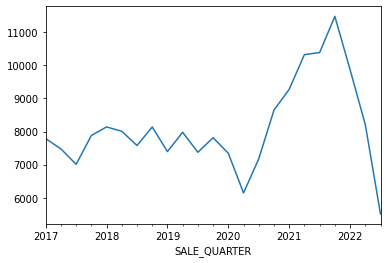

In [8]:
count_over_quarter = df.groupby('SALE_QUARTER')['SALE_DATE'].count()
count_over_quarter.plot()
count_over_quarter

In [9]:
import warnings
warnings.filterwarnings('ignore')

### It can be seen that the response variable, 'min investment accepted', is highly skewed. Even after log or rank transformation, we can see that it is still very uneven, and a large proportion of it lies at 0. This means that this variable cannot be fit into any existing distributions, which is an issue for hypothesis testing since we need to assume the variable follows some parametric distribution.

Text(0.5, 1.0, 'Density - Rank Transformed')

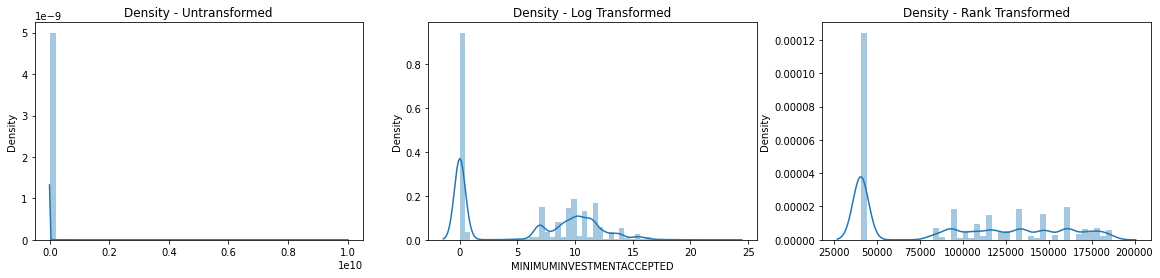

In [10]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(20, 4))

sns.distplot(df['MINIMUMINVESTMENTACCEPTED'].values, ax=axs[0])
axs[0].set_title("Density - Untransformed")

sns.distplot(np.log(1 + df['MINIMUMINVESTMENTACCEPTED']), ax=axs[1] )
axs[1].set_title("Density - Log Transformed")

sns.distplot(df['MINIMUMINVESTMENTACCEPTED'].rank().values, ax=axs[2] )
axs[2].set_title("Density - Rank Transformed")


### To deal with the aforementioned issue, we categorize/discretize the variable into bins.

In [11]:
df['MINIMUMINVESTMENTACCEPTED'].describe()

count    1.869570e+05
mean     5.712564e+05
std      3.532211e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+03
75%      2.700000e+04
max      1.000000e+10
Name: MINIMUMINVESTMENTACCEPTED, dtype: float64

In [12]:
for percentile in range(0, 100, 10):
    print(percentile, np.percentile(df['MINIMUMINVESTMENTACCEPTED'].values, percentile))

0 0.0
10 0.0
20 0.0
30 0.0
40 0.0
50 1000.0
60 10000.0
70 25000.0
80 50000.0
90 150000.0


### We categorize 'min investment amount' into 7 bins. The threshold are selected from quantiles of 'min investment accepted'.  
### The 7 bins now are:
### (-1.0, 0.0] < (0.0, 1000.0] < (1000.0, 10000.0] < (10000.0, 25000.0] < (25000.0, 50000.0] < (50000.0, 150000.0] < (150000.0, inf]
### Note that 'min investment accepted' contains only non-negative numbers, so the first bin represents 0 'min investment accepted'

In [30]:
BINS = [-1, 0, 1000, 10000, 25000, 50000, 150000, float('inf')]
df['min_invest_binned'] = pd.cut(df['MINIMUMINVESTMENTACCEPTED'], bins, )

In [31]:
df['min_invest_binned']

0         (25000.0, 50000.0]
1                (-1.0, 0.0]
2        (50000.0, 150000.0]
3         (10000.0, 25000.0]
4          (1000.0, 10000.0]
                ...         
12697      (1000.0, 10000.0]
12698        (150000.0, inf]
12699        (150000.0, inf]
12700     (25000.0, 50000.0]
12702            (-1.0, 0.0]
Name: min_invest_binned, Length: 186957, dtype: category
Categories (7, interval[float64, right]): [(-1.0, 0.0] < (0.0, 1000.0] < (1000.0, 10000.0] < (10000.0, 25000.0] < (25000.0, 50000.0] < (50000.0, 150000.0] < (150000.0, inf]]

Text(0.5, 1.0, 'Size of each Bin')

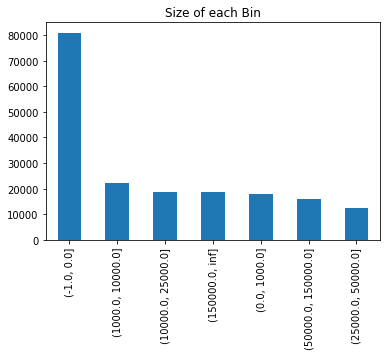

In [32]:
(df['min_invest_binned'].value_counts()).plot(kind='bar')
plt.title("Size of each Bin")

## Likelihood Ratio Test
In class, Chad derived the likelihood ratio test for testing constant volatility over a period of time. Similarly, here we use likelihood ratio test to test if proportion of a given bin $B$ if constant over time.  

Here $p_i$ denotes the probability that the 'min investment amount' of an observation from the $i^{th}$ quarter lies in bin $B$. For example, if $B$ = (0, 1000] and $i = 1$, then $p_i$ is the probability that a random observation from 2017Q1 has a 'min investment amount' between 0 and 1000.  
  
We form a hypothesis test:  
$H_0: p_1 = p_2 = ... = p_T$.  
$H_1: \exists i, j$ such that $p_i \neq p_j$.  

For the full derivation of the test statistic, see "Handwritten/Likelihood Ratio Test.pdf". The test statistics follows $Chi-squared(T - 1)$

## Mann-Kendall Test
The following content are obtained from this website; https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm
The Mann-Kendall(MK) Test is used for statistically assessing if there is a monotonic upward or downward trend of a variable over time.  
$H_0$: No monotonic trend.  
$H_1$: Monotonic trend is present.  
The assumption of independence means that the observations are not serially correlated over time. For this reason, in our analysis if the MK test detects no trend then we will proceed to test if autocorrelation exist within the time series.
One of the key assumptions of Mann-Kendall Test is that observations are i.i.d over time.

## Durb Watson Test
https://en.wikipedia.org/wiki/Durbin–Watson_statistic  
Durb Watson is a test statistic used to detect the presence of autocorrelation of lag 1 in the residuals from a regression analysis. 
   
$H_0$: No autocorrelation exist between in residuals.  
$H_1$: Autocorrelation exist between in residuals.  

The Durb-Watson statistic gives a number between 0 and 4. Closer it is to 2, higher the confidence we have to say that no autocorrelation exists. If the Durbin–Watson statistic is substantially less than 2, there is evidence of positive serial correlation. If the Durbin–Watson statistic is substantially greater than 2, there is evidence of negative serial correlation.  
However, the lower and upper critical values(rejection region at a given significance level) for durb-watson test are very hard to calculate, which is why we abandoned this method and adopted Ljung–Box test.

## Ljung–Box Test
https://en.wikipedia.org/wiki/Ljung–Box_test  
$H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).  
$H_1$: The data are not independently distributed; they exhibit serial correlation.  


In [75]:
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson as dwtest
import pymannkendall as mk
from statsmodels.stats.diagnostic import acorr_ljungbox

class ProportionAnalyzer:
    def __init__(self, df, start='2017-01-01', end='2023-01-01', alpha = 0.05):
        self.df = df.copy()
        self.df = self.df[(self.df['SALE_DATE'] >= start) & (self.df['SALE_DATE'] <= end)]
        # print(self.df['SALE_DATE'].describe())
        self.create_bins()
        self.alpha = alpha

    def create_bins(self):
        BINS = [-1, 0, 1000, 10000, 25000, 50000, 150000, float('inf')]
        # bins = np.array(bins)
        self.df['min_invest_binned'] = pd.cut(self.df['MINIMUMINVESTMENTACCEPTED'], BINS, )
        self.bins = [str(interval) for interval in sorted(self.df['min_invest_binned'].unique() )]

    def get_bin_count_over_quarter(self):
        bin_count_over_quarter = self.df.groupby(['SALE_QUARTER', 'min_invest_binned'])['ACCESSIONNUMBER'].count().reset_index(level=1)
        bin_count_over_quarter = bin_count_over_quarter.rename(columns = {'ACCESSIONNUMBER': 'COUNT'})
        bin_count_over_quarter.index = bin_count_over_quarter.index.to_timestamp()
        bin_total_count_over_quarter = bin_count_over_quarter.groupby(level=0)['COUNT'].sum()
        bin_total_count_over_quarter.name = 'TOTAL_COUNT_IN_BIN'
        bin_count_over_quarter = pd.merge(bin_count_over_quarter, bin_total_count_over_quarter, how = 'left',
        left_index=True, right_index= True
        )
        bin_count_over_quarter['ratio'] = bin_count_over_quarter['COUNT'] / bin_count_over_quarter['TOTAL_COUNT_IN_BIN']
        return bin_count_over_quarter
    
    def plot_bin_count(self, ax = None):
        bin_count_over_quarter = self.get_bin_count_over_quarter()
        for bin in bin_count_over_quarter['min_invest_binned'].unique():
            plt.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'COUNT'], 
                    label = bin,
                    # ax = ax
                    )
            plt.title('Minimum Investment Accepted Bin Count Over Time')
            plt.legend()
    
    def plot_bin_ratio(self, ax=None, title = ''):
        bin_count_over_quarter = self.get_bin_count_over_quarter()
        if ax:
            ax.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'ratio'], 
                    label = bin,
                    # ax = ax
                    )
            ax.settitle(title)
            ax.ylim(0, 1)
            ax.legend()

        for bin in bin_count_over_quarter['min_invest_binned'].unique():
            plt.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'ratio'], 
                    label = bin,
                    # ax = ax
                    )
            plt.title('Minimum Investment Accepted Bin Ratio Over Time')
            plt.ylim(0, 1)
            plt.legend()
    
    def get_bin_dummy(self):

        bin_dummy = pd.get_dummies(self.df['min_invest_binned']).reset_index(drop=True)
        bin_dummy.columns = self.bins
        bin_dummy = pd.concat([self.df['SALE_QUARTER'].reset_index(drop=True), bin_dummy], axis=1)
        return bin_dummy

    def bernoullie_max_ll(self, arr):
        return np.log(arr.mean(axis=0)) * arr.sum(axis=0) + np.log(1 - arr.mean(axis=0)) * (arr.shape[0] - arr.sum(axis=0))
    
    def likelihood_ratio_test(self):
        bin_dummy = self.get_bin_dummy()
        theta_under_null = bin_dummy.mean(axis=0)
        theta_under_alt = bin_dummy.groupby('SALE_QUARTER').mean()
        max_ll_under_null = self.bernoullie_max_ll(bin_dummy)
        max_ll_under_alt = bin_dummy.groupby('SALE_QUARTER')[self.bins].apply(self.bernoullie_max_ll)
        max_ll_under_alt = max_ll_under_alt.sum(axis=0)
        bin_dummy.groupby('SALE_QUARTER')[self.bins].apply(self.bernoullie_max_ll)
       
        m = self.df['SALE_QUARTER'].nunique()
        T = -2 * (max_ll_under_null - max_ll_under_alt)
        x = np.arange(0, 100, 0.001)
        plt.plot(x, scipy.stats.chi2.pdf(x, df=22))
        plt.title(f'Chi-squared distribution with {m - 1} degrees of freedom')

        p_values = pd.Series(scipy.stats.chi2.sf(T,  m - 1), index = self.bins)
        for bin, p_value in zip(self.bins, p_values):
            if p_value >= self.alpha:
                print(f"Likelihood ratio test concludes constant proportion over time for bin {bin}")
            else:
                print(f"Likelihood ratio test concludes changing proportion over time for bin {bin}")

        return p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt
    
    def man_kendall_test(self):
        bin_count = self.get_bin_count_over_quarter()
        for bin in bin_count['min_invest_binned'].unique():
            # print(bin)
            y = bin_count.loc[bin_count['min_invest_binned'] == bin, 'ratio']
            # X = np.array([[1] * y.shape[0], list(range(y.shape[0])) ]).T
            # print( f"test result of durb watson test:" )
            # print( dwtest(resids=sm.OLS(y, X).fit().resid)  )
            # print( f"Conducting Mann-Kendall Test" )
            mk_result = mk.original_test(y)
            if mk_result.trend != 'no trend':
                print(f"MK test detected {mk_result.trend} trend for bin {bin}")
            else:
                lb_result = acorr_ljungbox(y, 3)
                if (lb_result['lb_pvalue'] < self.alpha).any():
                    print(f"MK test detected no trend for bin {bin}, and L-b test detects autocorrelation, so we cannot reach any conclusion")
                else:
                    print(f"MK test detected no trend for bin {bin}, and L-b test detects no autocorrelation, so we can trust MK test")            
        # return mk_result, lb_result

### Overall proportion Analysis

Text(0.5, 1.0, 'Overall Relative Frequency over Time')

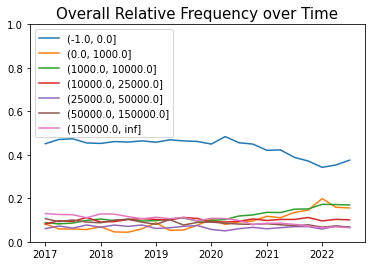

In [76]:
p = ProportionAnalyzer(df)
p.plot_bin_ratio()
plt.title('Overall Relative Frequency over Time', fontsize = 15)

Likelihood ratio test concludes changing proportion over time for bin (-1.0, 0.0]
Likelihood ratio test concludes changing proportion over time for bin (0.0, 1000.0]
Likelihood ratio test concludes changing proportion over time for bin (1000.0, 10000.0]
Likelihood ratio test concludes changing proportion over time for bin (10000.0, 25000.0]
Likelihood ratio test concludes changing proportion over time for bin (25000.0, 50000.0]
Likelihood ratio test concludes changing proportion over time for bin (50000.0, 150000.0]
Likelihood ratio test concludes changing proportion over time for bin (150000.0, inf]


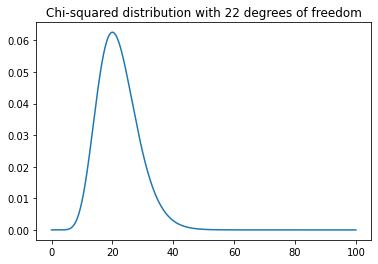

In [77]:
p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt = p.likelihood_ratio_test()

In [78]:
p.man_kendall_test()

MK test detected decreasing trend for bin (-1.0, 0.0]
MK test detected increasing trend for bin (0.0, 1000.0]
MK test detected increasing trend for bin (1000.0, 10000.0]
MK test detected no trend for bin (10000.0, 25000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (25000.0, 50000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected decreasing trend for bin (50000.0, 150000.0]
MK test detected decreasing trend for bin (150000.0, inf]


# Industry

In [79]:
df['INDUSTRYGROUPTYPE'].nunique()

35

In [80]:
df['INDUSTRYGROUPTYPE'].value_counts()

Pooled Investment Fund                  80815
Other Technology                        24358
Other                                   23746
Commercial                               8017
Other Real Estate                        7688
Other Health Care                        6267
Residential                              5206
Biotechnology                            4893
REITS and Finance                        4158
Investing                                3175
Other Banking and Financial Services     2227
Manufacturing                            2118
Oil and Gas                              1895
Retailing                                1765
Pharmaceuticals                          1549
Other Energy                             1226
Insurance                                1090
Business Services                        1086
Restaurants                               966
Commercial Banking                        924
Agriculture                               918
Computers                         

## Industry-Pooled Investment Fund

Text(0.5, 1.0, 'Pooled Investment Fund Relative Frequency Over Time')

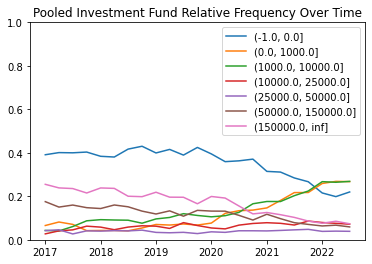

In [81]:
industry = 'Pooled Investment Fund'
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == industry])
p.plot_bin_ratio()
plt.title(f"{industry} Relative Frequency Over Time")

Likelihood ratio test concludes changing proportion over time for bin (-1.0, 0.0]
Likelihood ratio test concludes changing proportion over time for bin (0.0, 1000.0]
Likelihood ratio test concludes changing proportion over time for bin (1000.0, 10000.0]
Likelihood ratio test concludes changing proportion over time for bin (10000.0, 25000.0]
Likelihood ratio test concludes changing proportion over time for bin (25000.0, 50000.0]
Likelihood ratio test concludes changing proportion over time for bin (50000.0, 150000.0]
Likelihood ratio test concludes changing proportion over time for bin (150000.0, inf]


(-1.0, 0.0]             0.000000e+00
(0.0, 1000.0]           0.000000e+00
(1000.0, 10000.0]       0.000000e+00
(10000.0, 25000.0]      5.082815e-50
(25000.0, 50000.0]      2.751684e-05
(50000.0, 150000.0]    8.421515e-189
(150000.0, inf]         0.000000e+00
dtype: float64

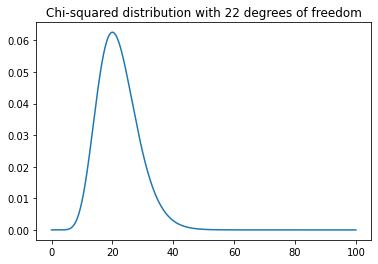

In [82]:
p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt = p.likelihood_ratio_test()
p_values

In [83]:
p.man_kendall_test()

MK test detected decreasing trend for bin (-1.0, 0.0]
MK test detected increasing trend for bin (0.0, 1000.0]
MK test detected increasing trend for bin (1000.0, 10000.0]
MK test detected increasing trend for bin (10000.0, 25000.0]
MK test detected no trend for bin (25000.0, 50000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected decreasing trend for bin (50000.0, 150000.0]
MK test detected decreasing trend for bin (150000.0, inf]


## Industry - Other Technology

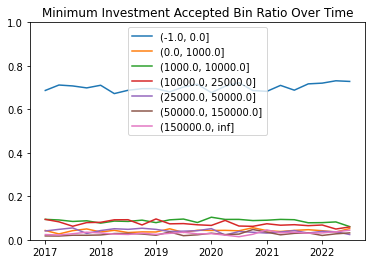

In [84]:
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == 'Other Technology'])
p.plot_bin_ratio()

Likelihood ratio test concludes constant proportion over time for bin (-1.0, 0.0]
Likelihood ratio test concludes constant proportion over time for bin (0.0, 1000.0]
Likelihood ratio test concludes constant proportion over time for bin (1000.0, 10000.0]
Likelihood ratio test concludes changing proportion over time for bin (10000.0, 25000.0]
Likelihood ratio test concludes changing proportion over time for bin (25000.0, 50000.0]
Likelihood ratio test concludes changing proportion over time for bin (50000.0, 150000.0]
Likelihood ratio test concludes changing proportion over time for bin (150000.0, inf]


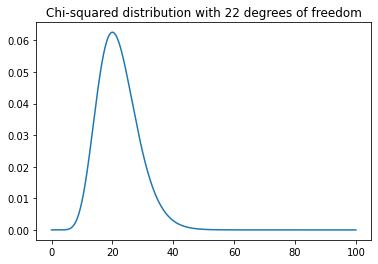

In [85]:
p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt = p.likelihood_ratio_test()

In [86]:
p.man_kendall_test()

MK test detected no trend for bin (-1.0, 0.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (0.0, 1000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (1000.0, 10000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected decreasing trend for bin (10000.0, 25000.0]
MK test detected decreasing trend for bin (25000.0, 50000.0]
MK test detected increasing trend for bin (50000.0, 150000.0]
MK test detected increasing trend for bin (150000.0, inf]


## Industry - Commercial

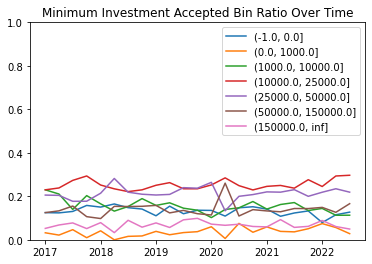

In [87]:
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == 'Commercial'])
p.plot_bin_ratio()

Likelihood ratio test concludes constant proportion over time for bin (-1.0, 0.0]
Likelihood ratio test concludes changing proportion over time for bin (0.0, 1000.0]
Likelihood ratio test concludes changing proportion over time for bin (1000.0, 10000.0]
Likelihood ratio test concludes constant proportion over time for bin (10000.0, 25000.0]
Likelihood ratio test concludes constant proportion over time for bin (25000.0, 50000.0]
Likelihood ratio test concludes changing proportion over time for bin (50000.0, 150000.0]
Likelihood ratio test concludes constant proportion over time for bin (150000.0, inf]


(-1.0, 0.0]            1.820135e-01
(0.0, 1000.0]          2.479443e-10
(1000.0, 10000.0]      2.327561e-04
(10000.0, 25000.0]     5.487928e-01
(25000.0, 50000.0]     1.104479e-01
(50000.0, 150000.0]    2.293663e-02
(150000.0, inf]        7.033539e-02
dtype: float64

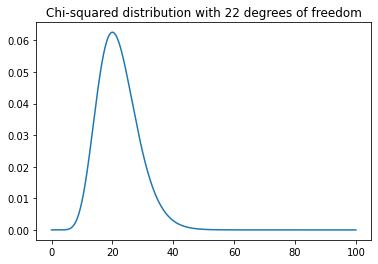

In [88]:
p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt = p.likelihood_ratio_test()
p_values

In [89]:
p.man_kendall_test()

MK test detected no trend for bin (-1.0, 0.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected increasing trend for bin (0.0, 1000.0]
MK test detected decreasing trend for bin (1000.0, 10000.0]
MK test detected no trend for bin (10000.0, 25000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (25000.0, 50000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (50000.0, 150000.0], and L-b test detects no autocorrelation, so we can trust MK test
MK test detected no trend for bin (150000.0, inf], and L-b test detects no autocorrelation, so we can trust MK test


In [96]:
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson as dwtest
import pymannkendall as mk
from statsmodels.stats.diagnostic import acorr_ljungbox

class ProportionAnalyzer:
    def __init__(self, df, start='2017-01-01', end='2023-01-01', alpha = 0.05):
        self.df = df.copy()
        self.df = self.df[(self.df['SALE_DATE'] >= start) & (self.df['SALE_DATE'] <= end)]
        # print(self.df['SALE_DATE'].describe())
        self.create_bins()
        self.alpha = alpha

    def create_bins(self):
        BINS = [-1, 0, 1000, 10000, 25000, 50000, 150000, float('inf')]
        # bins = np.array(bins)
        self.df['min_invest_binned'] = pd.cut(self.df['MINIMUMINVESTMENTACCEPTED'], BINS, )
        self.bins = [str(interval) for interval in sorted(self.df['min_invest_binned'].unique() )]

    def get_bin_count_over_quarter(self):
        bin_count_over_quarter = self.df.groupby(['SALE_QUARTER', 'min_invest_binned'])['ACCESSIONNUMBER'].count().reset_index(level=1)
        bin_count_over_quarter = bin_count_over_quarter.rename(columns = {'ACCESSIONNUMBER': 'COUNT'})
        bin_count_over_quarter.index = bin_count_over_quarter.index.to_timestamp()
        bin_total_count_over_quarter = bin_count_over_quarter.groupby(level=0)['COUNT'].sum()
        bin_total_count_over_quarter.name = 'TOTAL_COUNT_IN_BIN'
        bin_count_over_quarter = pd.merge(bin_count_over_quarter, bin_total_count_over_quarter, how = 'left',
        left_index=True, right_index= True
        )
        bin_count_over_quarter['ratio'] = bin_count_over_quarter['COUNT'] / bin_count_over_quarter['TOTAL_COUNT_IN_BIN']
        return bin_count_over_quarter
    
    def plot_bin_count(self, ax = None):
        bin_count_over_quarter = self.get_bin_count_over_quarter()
        for bin in bin_count_over_quarter['min_invest_binned'].unique():
            plt.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'COUNT'], 
                    label = bin,
                    # ax = ax
                    )
            plt.title('Minimum Investment Accepted Bin Count Over Time')
            plt.legend()
    
    def plot_bin_ratio(self, ax=None, title = ''):
        bin_count_over_quarter = self.get_bin_count_over_quarter()
        if ax:
            for bin in bin_count_over_quarter['min_invest_binned'].unique():
                ax.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'ratio'], 
                        label = bin,
                        # ax = ax
                        )
                ax.set_title(title)
                ax.set_ylim(0, 1)
                ax.legend()
        else:
            for bin in bin_count_over_quarter['min_invest_binned'].unique():
                plt.plot(bin_count_over_quarter.loc[bin_count_over_quarter['min_invest_binned'] == bin, 'ratio'], 
                        label = bin,
                        # ax = ax
                        )
                plt.title('Minimum Investment Accepted Bin Ratio Over Time')
                plt.ylim(0, 1)
                plt.legend()
    
    def get_bin_dummy(self):

        bin_dummy = pd.get_dummies(self.df['min_invest_binned']).reset_index(drop=True)
        bin_dummy.columns = self.bins
        bin_dummy = pd.concat([self.df['SALE_QUARTER'].reset_index(drop=True), bin_dummy], axis=1)
        return bin_dummy

    def bernoullie_max_ll(self, arr):
        return np.log(arr.mean(axis=0)) * arr.sum(axis=0) + np.log(1 - arr.mean(axis=0)) * (arr.shape[0] - arr.sum(axis=0))
    
    def likelihood_ratio_test(self):
        bin_dummy = self.get_bin_dummy()
        theta_under_null = bin_dummy.mean(axis=0)
        theta_under_alt = bin_dummy.groupby('SALE_QUARTER').mean()
        max_ll_under_null = self.bernoullie_max_ll(bin_dummy)
        max_ll_under_alt = bin_dummy.groupby('SALE_QUARTER')[self.bins].apply(self.bernoullie_max_ll)
        max_ll_under_alt = max_ll_under_alt.sum(axis=0)
        bin_dummy.groupby('SALE_QUARTER')[self.bins].apply(self.bernoullie_max_ll)
       
        m = self.df['SALE_QUARTER'].nunique()
        T = -2 * (max_ll_under_null - max_ll_under_alt)
        x = np.arange(0, 100, 0.001)
        plt.plot(x, scipy.stats.chi2.pdf(x, df=22))
        plt.title(f'Chi-squared distribution with {m - 1} degrees of freedom')

        p_values = pd.Series(scipy.stats.chi2.sf(T,  m - 1), index = self.bins)
        for bin, p_value in zip(self.bins, p_values):
            if p_value >= self.alpha:
                print(f"Likelihood ratio test concludes constant proportion over time for bin {bin}")
            else:
                print(f"Likelihood ratio test concludes changing proportion over time for bin {bin}")

        return p_values, theta_under_null, theta_under_alt, max_ll_under_null, max_ll_under_alt
    
    def man_kendall_test(self):
        bin_count = self.get_bin_count_over_quarter()
        for bin in bin_count['min_invest_binned'].unique():
            # print(bin)
            y = bin_count.loc[bin_count['min_invest_binned'] == bin, 'ratio']
            # X = np.array([[1] * y.shape[0], list(range(y.shape[0])) ]).T
            # print( f"test result of durb watson test:" )
            # print( dwtest(resids=sm.OLS(y, X).fit().resid)  )
            # print( f"Conducting Mann-Kendall Test" )
            mk_result = mk.original_test(y)
            if mk_result.trend != 'no trend':
                print(f"MK test detected {mk_result.trend} trend for bin {bin}")
            else:
                lb_result = acorr_ljungbox(y, 3)
                if (lb_result['lb_pvalue'] < self.alpha).any():
                    print(f"MK test detected no trend for bin {bin}, and L-b test detects autocorrelation, so we cannot reach any conclusion")
                else:
                    print(f"MK test detected no trend for bin {bin}, and L-b test detects no autocorrelation, so we can trust MK test")            
        # return mk_result, lb_result

Text(0.5, 0.98, 'Bin Relative Frequency of each Industry')

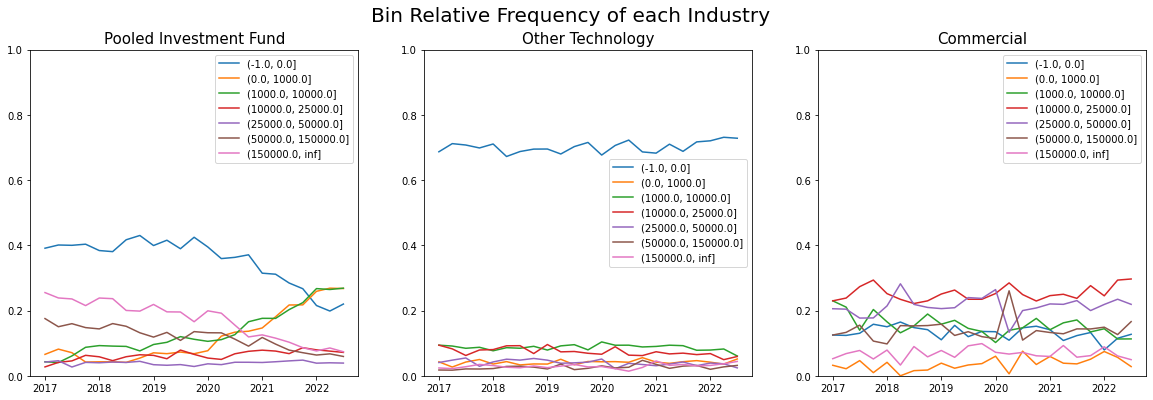

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
industry = 'Pooled Investment Fund'
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == industry])
p.plot_bin_ratio(ax=axs[0])
axs[0].set_title(f"Pooled Investment Fund", size=15)

industry = 'Other Technology'
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == industry])
p.plot_bin_ratio(ax=axs[1])
axs[1].set_title(f"Other Technology", size=15)

industry = 'Commercial'
p = ProportionAnalyzer(df[df['INDUSTRYGROUPTYPE'] == industry])
p.plot_bin_ratio(ax=axs[2])
axs[2].set_title(f"Commercial", size=15)

fig.suptitle('Bin Relative Frequency of each Industry', size = 20)